In [11]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv('C:\\Users\\Administrator\\Data Science\\Customers.csv')
products = pd.read_csv('C:\\Users\\Administrator\\Data Science\\Products.csv')
transactions = pd.read_csv('C:\\Users\\Administrator\\Data Science\\Transactions.csv')

In [12]:
# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [13]:
# Merge datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')


In [14]:
# Aggregate transaction data for customer-level features
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],  # Total, Average Spending, and Transaction Count
    'Quantity': 'sum',                      # Total Quantity Purchased
    'Category': lambda x: x.mode()[0]       # Most Purchased Category
}).reset_index()

In [15]:
# Rename columns for clarity
customer_features.columns = [
    'CustomerID', 'TotalSpending', 'AverageSpending', 'TransactionCount', 
    'TotalQuantity', 'MostPurchasedCategory'
]

In [16]:
# Merge customer profiles with aggregated features
customer_profiles = customers.merge(customer_features, on='CustomerID')

In [17]:
# Encode categorical variables
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region', 'MostPurchasedCategory'], drop_first=True)

In [18]:
# Scale numerical features
numerical_features = ['TotalSpending', 'AverageSpending', 'TransactionCount', 'TotalQuantity']
scaler = StandardScaler()
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])


In [19]:
# Select features for clustering
clustering_features = customer_profiles.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

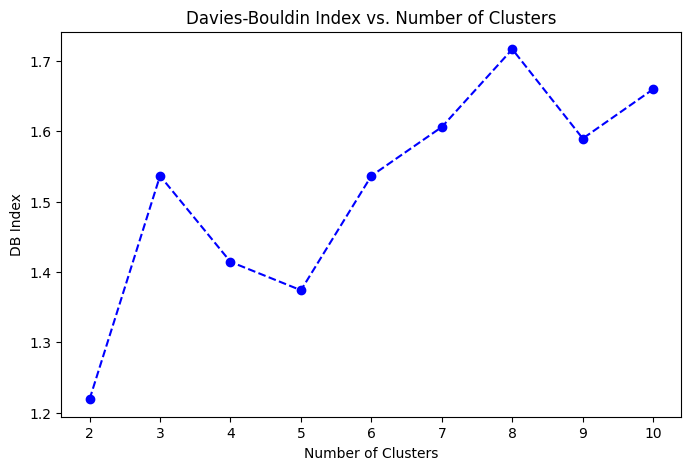

In [20]:
# Determine the optimal number of clusters using the DB Index
db_scores = []
clusters_range = range(2, 11)

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(clustering_features)
    db_index = davies_bouldin_score(clustering_features, cluster_labels)
    db_scores.append(db_index)

# Plot DB Index values
plt.figure(figsize=(8, 5))
plt.plot(clusters_range, db_scores, marker='o', linestyle='--', color='b')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

In [21]:
# Choose the optimal number of clusters (e.g., the one with the lowest DB Index)
optimal_clusters = clusters_range[db_scores.index(min(db_scores))]

In [22]:
# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(clustering_features)

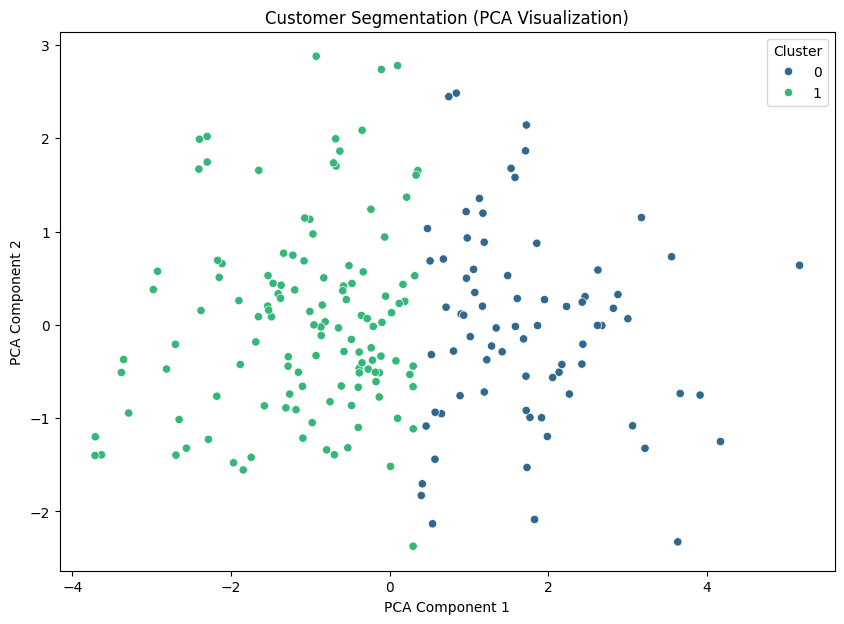

In [23]:
# Step 6: Visualize clusters using PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(clustering_features)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_features[:, 0], 
    y=pca_features[:, 1], 
    hue=customer_profiles['Cluster'], 
    palette='viridis',
    legend='full'
)
plt.title('Customer Segmentation (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [25]:
# Step 7: Save the clustering results
customer_profiles[['CustomerID', 'Cluster']].to_csv('C:\\Users\\Administrator\\Data Science\\Customer_Clusters.csv', index=False)

print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clusters: {min(db_scores):.4f}")

Optimal Number of Clusters: 2
DB Index for Optimal Clusters: 1.2189
